In [1]:
import os
import sys

sys.path.append(os.getcwd() + "/")

from experiments import setup_experiments

exps = setup_experiments("exp205")

In [9]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

no_bias_dir = Path(exps.path) / "test" / "no_bias"
bias_dir = Path(exps.path) / "test" / "bias"
csv = Path(exps.path) / "test.csv"

no_bias_macaw_cf_dir = Path(exps.path) / "macaw_cfs" / "no_bias"
bias_macaw_cf_dir = Path(exps.path) / "macaw_cfs" / "bias"

df = pd.read_csv(csv, low_memory=True)

In [28]:
macaw_pred_csv = Path(exps.path) / "macaw_cfs" / "no_bias" / "predictions.csv"
macaw_pred_df = pd.read_csv(macaw_pred_csv, low_memory=True)
macaw_pred_dict = dict(zip(macaw_pred_df["filename"], macaw_pred_df["predictions"]))
df["MACAW_SFCN_no_bias"] = df["filename"].map(macaw_pred_dict)

macaw_pred_csv = Path(exps.path) / "macaw_cfs" / "bias" / "predictions.csv"
macaw_pred_df = pd.read_csv(macaw_pred_csv, low_memory=True)
macaw_pred_dict = dict(zip(macaw_pred_df["filename"], macaw_pred_df["predictions"]))
df["MACAW_SFCN_bias"] = df["filename"].map(macaw_pred_dict)

In [29]:
from tifffile import tifffile as tiff


def four_images(idx, df):
    no_bias_img = tiff.imread(
        os.path.join(no_bias_dir, df.iloc[idx]["filename"])
    ).squeeze()
    bias_img = tiff.imread(os.path.join(bias_dir, df.iloc[idx]["filename"])).squeeze()

    no_bias_macaw_cf_img = tiff.imread(
        os.path.join(no_bias_macaw_cf_dir, df.iloc[idx]["filename"])
    ).squeeze()
    bias_macaw_cf_img = tiff.imread(
        os.path.join(bias_macaw_cf_dir, df.iloc[idx]["filename"])
    ).squeeze()

    return no_bias_img, bias_img, no_bias_macaw_cf_img, bias_macaw_cf_img

In [30]:
import numpy as np


def view_images(idx):
    no_bias_img, bias_img, no_bias_macaw, bias_macaw = four_images(idx, df)

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    [
        a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        for ax in axs
        for a in ax
    ]

    fig.delaxes(axs[0, 4])

    axs[0, 0].imshow(no_bias_img, cmap="gray")
    axs[0, 0].set_title("No bias")

    axs[0, 1].imshow(no_bias_macaw, cmap="gray")
    axs[0, 1].set_title("No bias CF")

    axs[0, 2].imshow(bias_img, cmap="gray")
    axs[0, 2].set_title("Bias")

    axs[0, 3].imshow(bias_macaw, cmap="gray")
    axs[0, 3].set_title("Bias CF")

    # fig.delaxes(axs[1, 0])

    axs[1, 0].imshow(bias_img - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 0].set_title("Bias - No bias")

    axs[1, 1].imshow(bias_img - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 1].set_title("Bias - No bias CF")

    axs[1, 2].imshow(bias_macaw - no_bias_img, cmap="seismic", clim=(-1, 1))
    axs[1, 2].set_title("Bias CF - No bias")

    axs[1, 3].imshow(no_bias_img - no_bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 3].set_title("No bias - No bias CF")

    axs[1, 4].imshow(bias_img - bias_macaw, cmap="seismic", clim=(-1, 1))
    axs[1, 4].set_title("Bias - Bias CF")

    fig.savefig("results/diff.png")

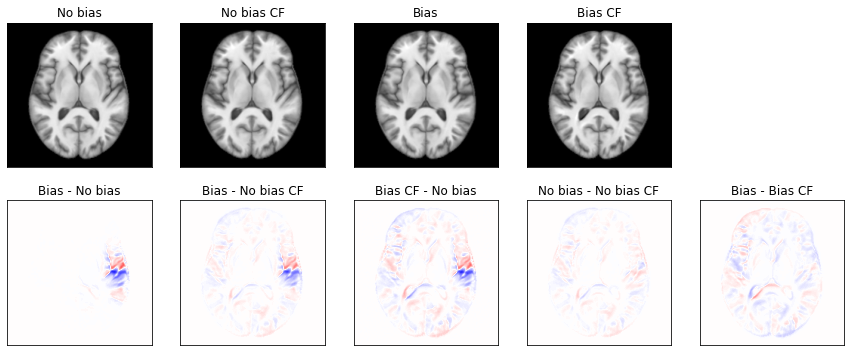

In [31]:
view_images(5)

In [32]:
def TEA(no_bias_img, bias_img, cf_img):
    no_far = (no_bias_img - bias_img).flatten()
    cf_far = (cf_img - bias_img).flatten()

    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far) / no_far_mag

    effectiveness = projection / no_far_mag
    amplification = np.sqrt(cf_far_mag**2 - projection**2)

    return effectiveness, amplification

In [33]:
n = len(df)

e_remove = []
a_remove = []

e_add = []
a_add = []

for i in range(n):
    no_bias, bias, no_bias_cf, bias_cf = four_images(i, df)

    e, a = TEA(no_bias, bias, no_bias_cf)
    e_remove.append(e)
    a_remove.append(a)

    e, a = TEA(bias, no_bias, bias_cf)
    e_add.append(e)
    a_add.append(a)

df["MACAW_e_remove"] = e_remove
df["MACAW_a_remove"] = a_remove

df["MACAW_e_add"] = e_add
df["MACAW_a_add"] = a_add

In [34]:
df["bias_effect"] = [float(i.split("_")[-2]) for i in df["filename"]]
df["disease_effect"] = [float(i.split("_")[3]) for i in df["filename"]]
df["subject_effect"] = [float(i.split("_")[1]) for i in df["filename"]]
df["isv_dst_abs"] = np.abs(df["isv_dst"])

NameError: name 'title' is not defined

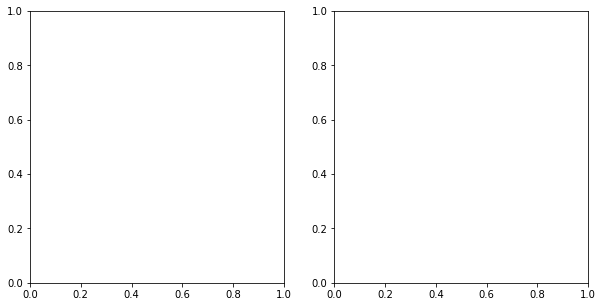

In [36]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(
    x="MACAW_e_remove",
    y="MACAW_a_remove",
    hue="MACAW_SFCN_no_bias",
    data=df,
    ax=axs[0],
    legend="full",
).legend(title="SFCN predictions", loc="upper right")

axs[0].set(
    title="MACAW - Removal",
    xlabel="Effectiveness",
    ylabel="Amplification",
    ylim=(0, 15),
)

sns.scatterplot(
    x="MACAW_e_add",
    y="MACAW_a_add",
    hue="MACAW_SFCN_bias",
    data=df,
    ax=axs[1],
    legend=False,
)
axs[1].set(
    title="MACAW - Addition",
    xlabel="Effectiveness",
    ylabel="Amplification",
    ylim=(0, 15),
)


fig.savefig("results/macaw_sfcn.png")

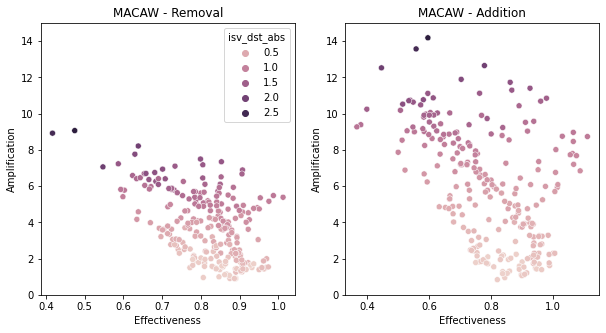

In [27]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(
    x="MACAW_e_remove",
    y="MACAW_a_remove",
    hue="isv_dst_abs",
    data=df,
    ax=axs[0],
)
axs[0].set(
    title="MACAW - Removal",
    xlabel="Effectiveness",
    ylabel="Amplification",
    ylim=(0, 15),
)

sns.scatterplot(
    x="MACAW_e_add",
    y="MACAW_a_add",
    hue="isv_dst_abs",
    data=df,
    ax=axs[1],
    legend=False,
)
axs[1].set(
    title="MACAW - Addition",
    xlabel="Effectiveness",
    ylabel="Amplification",
    ylim=(0, 15),
)


fig.savefig("results/macaw_isv.png")